# Blending and Stacking

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/fundamentals/blending-stacking.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘂𝘁𝗵𝗼𝗿: Ron Medina
𝗟𝗮𝘀𝘁 𝗠𝗼𝗱𝗶𝗳𝗶𝗲𝗱: 2022/07/14
𝗗𝗲𝘀𝗰𝗿𝗶𝗽𝘁𝗶𝗼𝗻: Implementing blending and stacking of machine learning models.
```

---

## Introduction

In this notebook, we will implement two ensembling techniques called **stacking** and **blending**. Ensembling techniques combine models to obtain better predictive performance than could be obtained from any single model. Combining models means that shortcomings of each single model get balanced out. 

Stacking and blending ensembles a diverse group of strong learners that are trained on the same task. In contrast to bagging which is also an ensembling technique that combines weak learners.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import time
import random
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Any, List, Dict, Union
from copy import deepcopy

from functools import partial, reduce
from scipy.optimize import minimize
from joblib import Parallel, delayed

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

seed = 42
np.random.seed(seed)
random.seed(seed)
        
NUM_FOLDS = 5

## IMDb Reviews Dataset

The dataset consists of 50,000 IMDb movie reviews selected for sentiment analysis. The sentiment of reviews is binary, with rating less than 5 is set to a sentiment score of 0, and rating at least 7 is set to a sentiment score of 1. No individual movie has more than 30 reviews.

```bash
USER="ymanojkumar023"
DATASET="kumarmanoj-bag-of-words-meets-bags-of-popcorn"
DATA_DIR=./data
kaggle datasets download -d ${USER}/${DATASET} -p ${DATA_DIR}
unzip ${DATA_DIR}/${DATASET}.zip -d ${DATA_DIR}/${DATASET} > /dev/null
rm ${DATA_DIR}/${DATASET}.zip
```

```text
100%|██████████████████████████████████████| 52.4M/52.4M [00:16<00:00, 3.38MB/s]
````

### Train and test split

In [2]:
data = pd.read_csv('./data/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv', sep='\t')

print(data.head())
print(data.shape)
data.sentiment.value_counts()

       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
(25000, 3)


1    12500
0    12500
Name: sentiment, dtype: int64

Perhaps a better approach would be to group reviews for the same movie in either the train of the test set. But we don't have that data available. 

## Stacking models

The idea with stacking is that predictions of models can be used as features to train new models. In principle, this process can be repeated indefinitely to train further models. To avoid overfitting, the process incorporates cross-validation folds. This just makes sure that data does not get leaked in the further layers.  


**Stacking algorithm with cross-validation**

1. Split train datasets into $k$ folds $({\mathsf X}_0, {\mathsf y}_0), \ldots, ({\mathsf X}_{k-1}, {\mathsf y}_{k-1})$ and set test dataset $\mathsf X.$
3. For $0 \leq i \leq k-1$ and for each base model $\mathsf m_q:$
    - Fit model $\mathsf m_q$ on $\bigcup_{j\neq i} ({\mathsf X}_j, {\mathsf y}_j).$ 
    - Predict probabilities ${{\mathsf p}^q}_i = \mathsf m_q({\mathsf X}_i)$ using trained model.
4. Fit model $\mathsf m_q$ on $\bigcup_j ({\mathsf X}_j, {\mathsf y}_j)$ and predict on $\mathsf X$ to get ${{\mathsf p}^q}.$
3. Stack predict probabilities to get metadatasets: 
    - $(\bar{\mathsf X}_0, {\mathsf y}_0), \ldots, (\bar{\mathsf X}_{k-1}, {\mathsf y}_{k-1})$ with $\bar{\mathsf X}_i = \left[{{\mathsf p}^1}_i \mid {{\mathsf p}^2}_i \mid \ldots \right]$
    - $\bar{\mathsf X} = \left[{\mathsf p}^1 \mid {\mathsf p}^2 \mid \ldots\right]$
4. Repeat for another set of models with the train and test metadatasets.


Note that after generating meta-features, the models will be retrained on the complete training set and predict on the test set to create test meta-features. This makes the test set look like an extra fold, so that cross-validation performance should be a good predictor of test performance.

### Training base models

Splitting the dataset and creating stratified folds:

In [3]:
train, test = train_test_split(
    data, 
    test_size=0.20, 
    shuffle=True, 
    random_state=seed
)

train = train.drop('id', axis=1).reset_index(drop=True)
test  = test .drop('id', axis=1).reset_index(drop=True)

skf = StratifiedKFold(n_splits=NUM_FOLDS)
train['fold'] = -1
for fold, (_, val_) in enumerate(skf.split(train.index, train.sentiment)):
    train.loc[val_, 'fold'] = fold

In [4]:
train.head()

,sentiment,review,fold
0,0,This movie is just plain dumb.<br /><br />From...,0
1,0,"Dahmer, a young confused man. Dahmer, a confus...",0
2,0,"May the saints preserve us, because this movie...",0
3,1,The combination of reading the Novella and vie...,0
4,1,Daniel Day Lewis in My Left Foot gives us one ...,0


In [5]:
test.head()

,sentiment,review
0,0,"I read that \There's a Girl in My Soup\"" came ..."
1,1,This film pulls you in from the get-go because...
2,0,From the awful death scenes to guns that fire ...
3,1,I saw that movie few days ago. This movie is s...
4,0,For a film with so much promise it was disappo...


Base models:

In [6]:
lr = make_pipeline(
        TfidfVectorizer(max_features=1000),
        LogisticRegression(random_state=seed)
)

lr_cnt = make_pipeline(
    CountVectorizer(),
    LogisticRegression(solver='liblinear', random_state=seed)
)

rf_svd = make_pipeline(
    TfidfVectorizer(max_features=None),
    TruncatedSVD(n_components=120, random_state=seed),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
)

Perform stacking algorithm:

In [7]:
basemodels = {
    'lr': lr, 
    'lr_cnt': lr_cnt, 
    'rf_svd': rf_svd
}

acc_score = lambda y_true, y_prob: accuracy_score(y_true, y_prob >= 0.5)
roc_score = lambda y_true, y_prob: roc_auc_score(y_true, y_prob)

cv_scores = {}
for q in basemodels.keys():
    print(f"\nLevel 0 preds: {q}")
    rocs = []
    accs = []
    for i in range(NUM_FOLDS):
        train_fld = train.query(f'fold != {i}')
        train_oof = train.query(f'fold == {i}')

        # Create train meta-features
        model = clone(basemodels[q])
        model.fit(
            X=train_fld.review.values, 
            y=train_fld.sentiment.values
        )
        p = model.predict_proba(train_oof.review.values)[:, 1]
        train.loc[train_oof.index, f"{q}_0"] = p

        # Compute cv scores
        roc = roc_score(train_oof.sentiment, p)
        acc = acc_score(train_oof.sentiment, p)
        rocs.append(roc)
        accs.append(acc)
        print(f"fold={i}, roc={roc:.4f}, acc={acc:.4f}")

    cv_scores[q] = {
        'roc': np.array(rocs),
        'acc': np.array(accs),
    }

    # Create test meta-features
    model = clone(basemodels[q])
    model.fit(
        X=train.review.values, 
        y=train.sentiment.values
    )
    test[f"{q}_0"] = model.predict_proba(test.review.values)[:, 1]


Level 0 preds: lr
fold=0, roc=0.9381, acc=0.8585
fold=1, roc=0.9325, acc=0.8570
fold=2, roc=0.9340, acc=0.8610
fold=3, roc=0.9295, acc=0.8502
fold=4, roc=0.9271, acc=0.8558

Level 0 preds: lr_cnt
fold=0, roc=0.9486, acc=0.8855
fold=1, roc=0.9419, acc=0.8765
fold=2, roc=0.9474, acc=0.8812
fold=3, roc=0.9436, acc=0.8780
fold=4, roc=0.9382, acc=0.8715

Level 0 preds: rf_svd
fold=0, roc=0.8831, acc=0.7985
fold=1, roc=0.8762, acc=0.7975
fold=2, roc=0.8792, acc=0.7973
fold=3, roc=0.8731, acc=0.7963
fold=4, roc=0.8795, acc=0.7995


### Generated meta-features

In [8]:
train.head()

,sentiment,review,fold,lr_0,lr_cnt_0,rf_svd_0
0,0,This movie is just plain dumb.<br /><br />From...,0,0.052181,0.001930,0.27
1,0,"Dahmer, a young confused man. Dahmer, a confus...",0,0.029885,0.000006,0.30
2,0,"May the saints preserve us, because this movie...",0,0.052702,0.000440,0.32
3,1,The combination of reading the Novella and vie...,0,0.917899,0.996462,0.65
4,1,Daniel Day Lewis in My Left Foot gives us one ...,0,0.982799,0.999165,0.86


In [9]:
test.head()

,sentiment,review,lr_0,lr_cnt_0,rf_svd_0
0,0,"I read that \There's a Girl in My Soup\"" came ...",0.021305,0.000098,0.17
1,1,This film pulls you in from the get-go because...,0.799816,0.673102,0.75
2,0,From the awful death scenes to guns that fire ...,0.066688,0.009249,0.17
3,1,I saw that movie few days ago. This movie is s...,0.969935,0.988239,0.65
4,0,For a film with so much promise it was disappo...,0.062784,0.000074,0.26


### Performance comparison

Performance of single models:

In [10]:
results = pd.DataFrame(
    index=[f"{q}_0" for q in basemodels.keys()] + ['xgb_1'],
    columns=['cv_acc', 'test_acc', 'cv_roc', 'test_roc']
)

for q in basemodels.keys():
    results.loc[f"{q}_0", 'test_acc'] = round(acc_score(test.sentiment, test[f'{q}_0']), 4)
    results.loc[f"{q}_0", 'test_roc'] = round(roc_score(test.sentiment, test[f'{q}_0']), 4)
    results.loc[f"{q}_0", 'cv_acc'] = f"{cv_scores[q]['acc'].mean():.4f} ± {cv_scores[q]['acc'].std():.4f}"
    results.loc[f"{q}_0", 'cv_roc'] = f"{cv_scores[q]['roc'].mean():.4f} ± {cv_scores[q]['roc'].std():.4f}"

Training a stacking model:

In [11]:
warnings.simplefilter(action='ignore')
columns = [c for c in train.columns if '_0' in c]
basemodels['xgb'] = XGBClassifier(seed=seed, eval_metric='logloss')
q = 'xgb'

print(f"\nLevel 1 preds: {q}")
rocs = []
accs = []
for i in range(NUM_FOLDS):
    train_fld = train.query(f'fold != {i}')
    train_oof = train.query(f'fold == {i}')

    # Create train meta-features
    model = clone(basemodels[q])
    model.fit(
        X=train_fld[columns].values, 
        y=train_fld.sentiment.values
    )
    p = model.predict_proba(train_oof[columns].values)[:, 1]
    train.loc[train_oof.index, f"{q}_1"] = p

    # Compute cv scores
    roc = roc_score(train_oof.sentiment, p)
    acc = acc_score(train_oof.sentiment, p)
    rocs.append(roc)
    accs.append(acc)
    print(f"fold={i}, roc={roc:.4f}, acc={acc:.4f}")

cv_scores[q] = {
    'roc': np.array(rocs),
    'acc': np.array(accs),
}

# Create test meta-features
model = clone(basemodels[q])
model.fit(
    X=train[columns].values, 
    y=train.sentiment.values
)
test[f"{q}_1"] = model.predict_proba(test[columns].values)[:, 1]


Level 1 preds: xgb
fold=0, roc=0.9488, acc=0.8838
fold=1, roc=0.9428, acc=0.8760
fold=2, roc=0.9470, acc=0.8760
fold=3, roc=0.9429, acc=0.8792
fold=4, roc=0.9378, acc=0.8738


### Initial results

In [12]:
results.loc[f"{q}_1", 'test_acc'] = round(acc_score(test.sentiment, test[f'{q}_1']), 4)
results.loc[f"{q}_1", 'test_roc'] = round(roc_score(test.sentiment, test[f'{q}_1']), 4)
results.loc[f"{q}_1", 'cv_acc'] = f"{cv_scores[q]['acc'].mean():.4f} ± {cv_scores[q]['acc'].std():.4f}"
results.loc[f"{q}_1", 'cv_roc'] = f"{cv_scores[q]['roc'].mean():.4f} ± {cv_scores[q]['roc'].std():.4f}"

Stacked model has relatively better test performance and within range of best cv-performance. This shows that stacking can significantly improve over single models.

In [13]:
results

,cv_acc,test_acc,cv_roc,test_roc
lr_0,0.8565 ± 0.0036,0.871,0.9322 ± 0.0038,0.9404
lr_cnt_0,0.8786 ± 0.0047,0.8838,0.9439 ± 0.0038,0.9473
rf_svd_0,0.7978 ± 0.0011,0.7976,0.8782 ± 0.0034,0.8794
xgb_1,0.8778 ± 0.0035,0.886,0.9439 ± 0.0038,0.9498


## Stacking with warm start

Note the modular nature of the algorithm allowed us to copy the code above with minimal change for the XGBoost metamodel. This allows us to collect all our work above in a single class, allowing automated training and inference. To indicate the number of rounds of stacking performed, we introduce **levels**. This is analogous to layers in a neural network. 

We also include **warm starting**. This means that we use earlier levels in a trained stacker and stack them with layers. Only the new layers will be trained. It adds some complexity to the implementation, but warm-starting is a desirable feature, especially when training base models are expensive and we want to perform rapid iteration only on top models.

In [14]:
class StackingClassifier:
    """Implements model stacking with predict probabilities."""

    def __init__(self, 
            models: List[Dict[str, Any]], 
            metrics: Dict[str, Any] = None,
            verbose: int = 1,
            num_folds: int = 5,

            # advanced usage
            warm_start_level = None,
            warm_start_stack = None,
        ):
        """
        params
            models (list[dict]):
                List of dicts of name-model pairs for each level
                    1) unique names level-wise
                    2) single model at last level
                    3) model implements fit and predict_proba

            verbose   (int): Verbosity level, 0 = not verbose, 1 = verbose
            num_folds (int): No. of (stratified) cross-validation folds
            
            metrics (dict[str, any]): 
                Name-metric pairs for such that metric is a function of 
                (y_true, y_predict_proba).

        advanced params
            warm_start_level (int >= 1): 
                Use levels of existing trained stack < warm_start_level.
            
            warm_start_stack (instance of this class): 
                Use models and features from this stack so that predictions 
                of single models can be easily combined. And earlier models 
                need not be retrained.
                    1) assumes earlier levels have trained models
                    2) assumes earlier levels have metafeatures
                    3) passed `self.models` will be appended to model dict list
                       up to warm start level
                    4) metrics are either inherited or updated by passed value.
        
        Example:
        >>> models = [
            {'l1_model1': l1_model1, 'l1_model2': l1_model2},
            {'l2_model1': l2_model1},
        ]
        >>> metrics = {
            'roc': lambda y_true, y_prob:  roc_auc_score(y_true, y_prob),
            'acc': lambda y_true, y_prob: accuracy_score(y_true, y_prob >= 0.5)
        }
        >>> stacked_model = StackingClassifier(models, metrics=metrics)
        """

        self.models = [{m: deepcopy(d[m]) for m in d.keys()} for d in models]
        self.verbose = verbose
        self.num_folds = num_folds
        self.cv_scores_ = {}
        self.train_ = None
        self.metrics = {'roc_score':  roc_auc_score} if metrics is None else metrics
        
        # Warm starting
        assert (warm_start_level is None) == (warm_start_stack is None)
        if warm_start_level is not None:
            self.warm_level = warm_start_level
            self.warm_stack = warm_start_stack

            # Ignore upper level meta-features of reference stack
            skip = set()
            for l in range(self.warm_level, len(self.warm_stack.models)):
                for q in self.warm_stack.models[l].keys():
                    skip.add(f"{q}_{l}")

            _ = self.warm_stack.train_
            self.train_ = _[[c for c in _.columns if c not in skip]]
            
            # Select cv scores of reference stack to include
            for i in range(self.warm_level):
                for k in [_ for _ in self.warm_stack.cv_scores_.keys() if f"_{i}" in _]:
                    self.cv_scores_[k] = self.warm_stack.cv_scores_[k]
            
            # Update metrics to reference stack if None, else use passed metrics
            self.metrics = self.warm_stack.metrics if metrics is None else metrics
            
            # Base models + stack top models
            self.models = self.warm_stack.models[:self.warm_level] + self.models
            
            # Warm start model
            self.fit(
                self.train_.drop(['fold', 'target'], axis=1), 
                self.train_.target, 
                start_level=self.warm_level
            )
    
    def fit(self, X: Union[pd.DataFrame, np.array], y: np.array, start_level=0):
        """Iteratively fit base models with metafeatures.
        
        params
            X (pd.DataFrame or 2D-ndarray): Some constraints:
                1) X must not have column 'fold'
                2) X must not have column 'target'
                3) X must not have column f'{q}_{level}' where q is a model name 
                   and level = 0, ... , max_level - 1.

            y (1D-ndarray or pd.Series): Target array with 0 or 1 as entries.
        """

        # Validate data (read docstring above)
        train = pd.DataFrame(X)

        # Create folds
        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=False)
        train['target'] = y
        train['fold'] = -1
        for fold, (_, val_) in enumerate(skf.split(train.index, y)):
            train.loc[val_, 'fold'] = fold
        
        # Create metafeatures for each level
        for level in range(start_level, len(self.models)):
            basemodels = self.models[level]
            columns = [c for c in train.columns if f'_{level-1}' in str(c)] if level >= 1 else train.columns.drop(['fold', 'target'])
            for q, model in basemodels.items():
                if self.verbose:
                    print(f"\nLevel {level} preds: {q}")
    
                self.cv_scores_[f"{q}_{level}"] = {metric:[] for metric in self.metrics.keys()}
                for i in range(self.num_folds):
                    train_fld = train.query(f'fold != {i}')
                    train_oof = train.query(f'fold == {i}')

                    # Create train meta-features
                    model_ = deepcopy(model)
                    model_.fit(
                        X=train_fld[columns], 
                        y=train_fld.target
                    )
                    p = model_.predict_proba(train_oof[columns])[:, 1]
                    train.loc[train_oof.index, f"{q}_{level}"] = p

                    # Compute cv scores
                    message = []
                    for metric, metric_fn in self.metrics.items():
                        score = metric_fn(train_oof.target, p)
                        self.cv_scores_[f"{q}_{level}"][metric].append(score)
                        message.append(f'{metric}={score:.4f}')
                    
                    if self.verbose:
                        print(f"fold={i}, {', '.join(message)}")

                # Fit on entire train for inference
                self.models[level][q] = model.fit(train[columns], train.target)

        # Save features table
        self.train_ = train

        return self


    def predict_proba(self, X):
        """Return 2D ndarray of prediction probabilities.
        params
            X (pd.DataFrame or 2D ndarray): This input is assumed 
            to have the same form as that used for training.
        """

        # Predict with trained models
        test = pd.DataFrame(X)
        for level, basemodels in enumerate(self.models):
            columns = [c for c in test.columns if f'_{level-1}' in str(c)] if level >= 1 else test.columns
            for q, model in basemodels.items():
                pred = model.predict_proba(test[columns])[:, 1]
                test[f"{q}_{level}"] = pred
        
        # Return prediction of top-most model.
        test_pred = test[f"{list(self.models[-1].keys())[0]}_{len(self.models)-1}"]
        return np.c_[1-test_pred, test_pred]

The vectorizers expect 1-dimensional vectors$,$ so we define a helper transformer:

In [15]:
class ReviewColumnExtractor(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): 
        return X.review.values.reshape(-1)

lr = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=1000),
    LogisticRegression(random_state=seed)
)

lr_cnt = make_pipeline(
    ReviewColumnExtractor(),
    CountVectorizer(),
    LogisticRegression(solver='liblinear', random_state=seed)
)

rf_svd = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=None),
    TruncatedSVD(n_components=120, random_state=seed),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
)

Fitting the stacked models:

In [16]:
models = [
    {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd},
    {'xgb': XGBClassifier(seed=seed, eval_metric='logloss')}
]

metrics = {
    'roc': lambda y_true, y_prob:  roc_auc_score(y_true, y_prob),
    'acc': lambda y_true, y_prob: accuracy_score(y_true, y_prob >= 0.5)
}

stack = StackingClassifier(models, metrics=metrics)
stack.fit(train[['review']], train.sentiment);


Level 0 preds: lr
fold=0, roc=0.9381, acc=0.8585
fold=1, roc=0.9325, acc=0.8570
fold=2, roc=0.9340, acc=0.8610
fold=3, roc=0.9295, acc=0.8502
fold=4, roc=0.9271, acc=0.8558

Level 0 preds: lr_cnt
fold=0, roc=0.9486, acc=0.8855
fold=1, roc=0.9419, acc=0.8765
fold=2, roc=0.9474, acc=0.8812
fold=3, roc=0.9436, acc=0.8780
fold=4, roc=0.9382, acc=0.8715

Level 0 preds: rf_svd
fold=0, roc=0.8831, acc=0.7985
fold=1, roc=0.8762, acc=0.7975
fold=2, roc=0.8792, acc=0.7973
fold=3, roc=0.8731, acc=0.7963
fold=4, roc=0.8795, acc=0.7995

Level 1 preds: xgb
fold=0, roc=0.9488, acc=0.8838
fold=1, roc=0.9428, acc=0.8760
fold=2, roc=0.9470, acc=0.8760
fold=3, roc=0.9429, acc=0.8792
fold=4, roc=0.9378, acc=0.8738


Generated probability features can be accessed as follows:

In [17]:
stack.train_.head()

,review,target,fold,lr_0,lr_cnt_0,rf_svd_0,xgb_1
0,This movie is just plain dumb.<br /><br />From...,0,0,0.052181,0.001930,0.27,0.011519
1,"Dahmer, a young confused man. Dahmer, a confus...",0,0,0.029885,0.000006,0.30,0.023870
2,"May the saints preserve us, because this movie...",0,0,0.052702,0.000440,0.32,0.007410
3,The combination of reading the Novella and vie...,1,0,0.917899,0.996462,0.65,0.977768
4,Daniel Day Lewis in My Left Foot gives us one ...,1,0,0.982799,0.999165,0.86,0.998865


Hacking into the models allow us to compute train and test results for single models:

In [44]:
# Compute train cv results table
index = []
for level in range(len(stack.models)-1):
    for q in stack.models[level].keys():
        index.append(f"{q}_{level}")

results = pd.DataFrame(
    index=index,
    columns=[f'cv_{metric}' for metric in stack.metrics.keys()] + [f'test_{metric}' for metric in stack.metrics.keys()]
)

# Compute cv scores
for level in range(len(stack.models)-1):
    for metric in stack.metrics.keys():
        for q in stack.models[level].keys():                        
            cv_scores = np.array(stack.cv_scores_[f"{q}_{level}"][metric])
            results.loc[f"{q}_{level}", f'cv_{metric}'] = f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"

# Compute test scores
for metric, metric_fn in stack.metrics.items():
    for q in stack.models[0].keys():
        results.loc[f"{q}_0", f'test_{metric}'] = round(metric_fn(test.sentiment, stack.models[0][f'{q}'].predict_proba(test[['review']])[:, 1]), 4)
        results.loc[f"{q}_0", f'test_{metric}'] = round(metric_fn(test.sentiment, stack.models[0][f'{q}'].predict_proba(test[['review']])[:, 1]), 4)
        results.loc[f"{q}_0", f'test_{metric}'] = round(metric_fn(test.sentiment, stack.models[0][f'{q}'].predict_proba(test[['review']])[:, 1]), 4)

results.T

,lr_0,lr_cnt_0,rf_svd_0
cv_roc,0.9322 ± 0.0038,0.9439 ± 0.0038,0.8782 ± 0.0034
cv_acc,0.8565 ± 0.0036,0.8786 ± 0.0047,0.7978 ± 0.0011
test_roc,0.9404,0.9473,0.8794
test_acc,0.871,0.8838,0.7976


For convenience, we define a helper function for updating results for new stacks:

In [19]:
def update_results(results, stack):

    # Get name of final model
    l = len(stack.models) - 1
    q = list(stack.models[-1].keys())[0]

    # Compute cv scores
    for metric, metric_fn in stack.metrics.items():
        cv_scores = np.array(stack.cv_scores_[f"{q}_{l}"][metric])
        results.loc[f"{q}_{l}", f'cv_{metric}'] = f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"
        
        # Compute test scores
        test_pred = stack.predict_proba(test[['review']])[:, 1]
        score = metric_fn(test['sentiment'], test_pred)
        results.loc[f"{q}_{l}", f'test_{metric}'] = round(score, 4)

    return results

### Reproducing initial results

In [20]:
results = update_results(results, stack) # xgb stack
results.T

,lr_0,lr_cnt_0,rf_svd_0,xgb_1
cv_roc,0.9322 ± 0.0038,0.9439 ± 0.0038,0.8782 ± 0.0034,0.9439 ± 0.0038
cv_acc,0.8565 ± 0.0036,0.8786 ± 0.0047,0.7978 ± 0.0011,0.8778 ± 0.0035
test_roc,0.9404,0.9473,0.8794,0.9498
test_acc,0.871,0.8838,0.7976,0.886


The results are consistent with what we obtained above. This means that our involved implementation somehow worked and is able to produce reproducible results.

## Blending

Blending simply takes the weighted average of the prediction probabilities of base models as the final prediction probability. We will use the same base models that we used above. This works best when the base probabilities uncorrelated:

In [21]:
stack.train_[['lr_0', 'lr_cnt_0', 'rf_svd_0']].corr()

,lr_0,lr_cnt_0,rf_svd_0
lr_0,1.000000,0.884571,0.832398
lr_cnt_0,0.884571,1.000000,0.727050
rf_svd_0,0.832398,0.727050,1.000000


Let's try to blend the probabilities using some hand-designed coefficients.

In [22]:
# AUC is scale invariant, so we dont bother dividing by total weights
metafeatures = stack.train_[['lr_0', 'lr_cnt_0', 'rf_svd_0']]
avg_preds = (metafeatures * [1, 1, 1]).sum(axis=1)
wtd_preds = (metafeatures * [1, 3, 1]).sum(axis=1)
rank_avg_preds = (metafeatures.rank() * [1, 1, 1]).sum(axis=1)
rank_wtd_preds = (metafeatures.rank() * [1, 3, 1]).sum(axis=1)

print(f"auc (train) (averaged):       {roc_auc_score(train.sentiment.values, avg_preds):.4f}")
print(f"auc (train) (wtd. avg):       {roc_auc_score(train.sentiment.values, wtd_preds):.4f}")
print(f"auc (train) (rank avg):       {roc_auc_score(train.sentiment.values, rank_avg_preds):.4f}") 
print(f"auc (train) (wtd. rank avg):  {roc_auc_score(train.sentiment.values, rank_wtd_preds):.4f}")

auc (train) (averaged):       0.9468
auc (train) (wtd. avg):       0.9483
auc (train) (rank avg):       0.9423
auc (train) (wtd. rank avg):  0.9486


### Optimizing AUC

Since these coefficients are hand-designed, we may want to devise a strategy for automatically finding the optimal coefficients for blending. This is accomplished by the folowing class.

In [23]:
class Blender:
    """Implement blending that maximizes AUC score."""
    
    def __init__(self, rank=False, random_state=42):
        self.coef_ = None
        self.rank = rank
        self.random_state = random_state

    def fit(self, X, y):
        """Find optimal blending coefficients."""
        
        X = pd.DataFrame(X)
        if self.rank:
            X = X.rank()

        self.coef_ = self._optimize_auc(X, y)
        return self

    def predict_proba(self, X):
        """Return blended probabilities for class 0 and class 1."""
        
        X = pd.DataFrame(X)
        if self.rank:
            X = X.rank()
            
        pred = np.sum(X * self.coef_, axis=1)
        return np.c_[1 - pred, pred]

    def _auc(self, coef, X, y):
        """Calculate AUC of blended predict probas."""

        auc = roc_auc_score(y, np.sum(X * coef, axis=1))
        return -1.0 * auc # min -auc = max auc
    
    def _optimize_auc(self, X, y):
        """
        Maximize AUC as a bound-constrained optimization problem using Nelder-Mead method 
        with coefficients initialized from a Dirichlet distribution with a = [1, ..., 1]. 
        
        Reference: 
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
        """
        partial_loss = partial(self._auc, X=X, y=y) 
        rng = np.random.RandomState(self.random_state)
        init_coef = rng.dirichlet(np.ones(X.shape[1]))
        return minimize(partial_loss, init_coef, 
                        method='Nelder-Mead', 
                        bounds=[(0, 1)]*X.shape[1])['x']

Calculating CV scores for blender model by warm-starting previous trained stack:

In [24]:
blender_stack = StackingClassifier(
    models=[{'blender': Blender()}],
    warm_start_level=1,
    warm_start_stack=stack
)


Level 1 preds: blender
fold=0, roc=0.9540, acc=0.8875
fold=1, roc=0.9473, acc=0.8588
fold=2, roc=0.9516, acc=0.8688
fold=3, roc=0.9460, acc=0.8675
fold=4, roc=0.9437, acc=0.8610


Note that the metrics are inherited from the reference stack since we provided none. Also note that level 1 meta-features are not inherited by the warm-started stack. The inherited models are also only up to the warm start level.

In [25]:
blender_stack.train_.head()

,review,lr_0,lr_cnt_0,rf_svd_0,target,fold,blender_1
0,This movie is just plain dumb.<br /><br />From...,0.052181,0.001930,0.27,0,0,0.032093
1,"Dahmer, a young confused man. Dahmer, a confus...",0.029885,0.000006,0.30,0,0,0.028978
2,"May the saints preserve us, because this movie...",0.052702,0.000440,0.32,0,0,0.035302
3,The combination of reading the Novella and vie...,0.917899,0.996462,0.65,1,0,0.718977
4,Daniel Day Lewis in My Left Foot gives us one ...,0.982799,0.999165,0.86,1,0,0.749406


In [26]:
blender_stack.models

[{'lr': Pipeline(steps=[('reviewcolumnextractor', ReviewColumnExtractor()),
                  ('tfidfvectorizer', TfidfVectorizer(max_features=1000)),
                  ('logisticregression', LogisticRegression(random_state=42))]),
  'lr_cnt': Pipeline(steps=[('reviewcolumnextractor', ReviewColumnExtractor()),
                  ('countvectorizer', CountVectorizer()),
                  ('logisticregression',
                   LogisticRegression(random_state=42, solver='liblinear'))]),
  'rf_svd': Pipeline(steps=[('reviewcolumnextractor', ReviewColumnExtractor()),
                  ('tfidfvectorizer', TfidfVectorizer()),
                  ('truncatedsvd',
                   TruncatedSVD(n_components=120, random_state=42)),
                  ('randomforestclassifier',
                   RandomForestClassifier(n_jobs=-1, random_state=42))])},
 {'blender': <__main__.Blender at 0x17737ec10>}]

### Results with blending

Adding blending scores to results table. Blending has significantly better AUC scores.

In [27]:
results = update_results(results, blender_stack)
results.T

,lr_0,lr_cnt_0,rf_svd_0,xgb_1,blender_1
cv_roc,0.9322 ± 0.0038,0.9439 ± 0.0038,0.8782 ± 0.0034,0.9439 ± 0.0038,0.9485 ± 0.0038
cv_acc,0.8565 ± 0.0036,0.8786 ± 0.0047,0.7978 ± 0.0011,0.8778 ± 0.0035,0.8687 ± 0.0101
test_roc,0.9404,0.9473,0.8794,0.9498,0.9538
test_acc,0.871,0.8838,0.7976,0.886,0.8794


Doing the same for blending with rank. Note that don't have an accuracy metric. This is because we only use this type of model for comparing scores.

In [28]:
blender_metrics = {'roc': roc_auc_score}

blender_rk_stack = StackingClassifier(
    models=[{'blender_rk': Blender(rank=True)}],
    metrics=blender_metrics,
    warm_start_level=1,
    warm_start_stack=stack
)


Level 1 preds: blender_rk
fold=0, roc=0.9544
fold=1, roc=0.9481
fold=2, roc=0.9527
fold=3, roc=0.9477
fold=4, roc=0.9437


### Results with blending ranked probabilities

Blending ranked probabilities has even better cross-validation scores for AUC compared to blending raw probabilities. Recall that we observed the same phenomenon above for hand picked coefficients.

In [29]:
results = update_results(results, blender_rk_stack)
results.T

,lr_0,lr_cnt_0,rf_svd_0,xgb_1,blender_1,blender_rk_1
cv_roc,0.9322 ± 0.0038,0.9439 ± 0.0038,0.8782 ± 0.0034,0.9439 ± 0.0038,0.9485 ± 0.0038,0.9493 ± 0.0038
cv_acc,0.8565 ± 0.0036,0.8786 ± 0.0047,0.7978 ± 0.0011,0.8778 ± 0.0035,0.8687 ± 0.0101,NaN
test_roc,0.9404,0.9473,0.8794,0.9498,0.9538,0.9537
test_acc,0.871,0.8838,0.7976,0.886,0.8794,NaN


**Remark.** If we assume that each fold has the same error distribution, then cross-validation performance should approximate the test AUC which can be thought of as just another fold of training data. Indeed, we can see this from the above results.

## Parallelizing Training

Generating features require training each model on each fold. This is very slow. Note that each training process are independent of each other as they only use static features from the previous level, so in principle can be easily parallelized. Note that we parallelize only the training on cross-validation folds.

**Remarks.** Parallelizing training on cross-validation folds is implemented using `joblib.Parallel`. Here we set `backend='loky'` as this is the setting that works on an M1. Also, setting `nthread=1` for XGBClassifier with backend `loky` and `n_jobs=-1`. Other settings result in worse times. See this [issue](https://github.com/dmlc/xgboost/issues/2163). 

Since joblib pickles every object used inside `Parallel`, we have to use stateless objects and be careful about shared memory. Results below show that there is significant speed up with parallelization using the `loky` backend.

In [30]:
class StackingClassifierParallel:
    """Implements model stacking with predict probabilities."""

    def __init__(self, 
            models: List[Dict[str, Any]], 
            metrics: Dict[str, Any] = None,
            verbose: bool = True,
            num_folds: int = 5,
            backend: str = 'loky',
            n_jobs: int = 1,

            # Advanced usage
            warm_start_level = None,
            warm_start_stack = None,
        ):
        """
        params
            models (list[dict]):
                List of dicts of name-model pairs for each level
                    1) unique names level-wise
                    2) single model at last level
                    3) model implements fit and predict_proba

            verbose   (int): Verbosity level, 0 = not verbose, 1 = verbose
            num_folds (int): No. of (stratified) cross-validation folds
            
            metrics (dict[str, any]): 
                Name-metric pairs for such that metric is a function of 
                (y_true, y_predict_proba). Defaults to {'roc_score': roc_auc_score}

            backend (str): Backend for internal joblib.Parallel object.    
            n_jobs  (int): No. of jobs passed to internal joblib.Parallel object.


        advanced params
            warm_start_level (int >= 1): 
                Use levels of existing trained stack < warm_start_level.
            
            warm_start_stack (instance of this class): 
                Use models and features from this stack so that predictions 
                of single models can be easily combined. And earlier models 
                need not be retrained.
                    1) assumes earlier levels have trained models
                    2) assumes earlier levels have metafeatures
                    3) passed `self.models` will be appended to model dict list
                       up to warm start level.
                    4) metrics are either inherited or updated by passed value.
        
        Example:
        >>> models = [
            {'l1_model1': l1_model1, 'l1_model2': l1_model2},
            {'l2_model1': l2_model1},
        ]
        >>> metrics = {
            'roc': lambda y_true, y_prob:  roc_auc_score(y_true, y_prob),
            'acc': lambda y_true, y_prob: accuracy_score(y_true, y_prob >= 0.5)
        }
        >>> stacked_model = StackingClassifierParallel(models, metrics=metrics)
        """

        self.models = [{m: deepcopy(d[m]) for m in d.keys()} for d in models]
        self.verbose = verbose
        self.num_folds = num_folds
        self.cv_scores_ = {}
        self.train_ = None
        self.metrics = {'roc_score':  roc_auc_score} if metrics is None else metrics
        self.backend = backend
        self.n_jobs = n_jobs

        # Warm starting
        assert (warm_start_level is None) == (warm_start_stack is None)
        if warm_start_level is not None:
            self.warm_level = warm_start_level
            self.warm_stack = warm_start_stack

            # Ignore upper level meta-features of reference stack
            skip = set()
            for l in range(self.warm_level, len(self.warm_stack.models)):
                for q in self.warm_stack.models[l].keys():
                    skip.add(f"{q}_{l}")

            _ = self.warm_stack.train_
            self.train_ = _[[c for c in _.columns if c not in skip]]
            
            # Select cv scores of reference stack to include
            for i in range(self.warm_level):
                for k in [_ for _ in self.warm_stack.cv_scores_.keys() if f"_{i}" in _]:
                    self.cv_scores_[k] = self.warm_stack.cv_scores_[k]
            
            # Update metrics to reference stack if None, else use passed metrics
            self.metrics = self.warm_stack.metrics if metrics is None else metrics
            
            # Base models + stack top models
            self.models = self.warm_stack.models[:self.warm_level] + self.models
            
            # Warm start model
            self.fit(
                self.train_.drop(['fold', 'target'], axis=1), 
                self.train_.target, 
                start_level=self.warm_level
            )
    
    
    def fit(self, X: Union[pd.DataFrame, np.array], y: np.array, start_level=0):
        """Iteratively fit base models with metafeatures.
        
        params
            X (pd.DataFrame or 2D-ndarray): Some constraints:
                1) X must not have column 'fold'
                2) X must not have column 'target'
                3) X must not have column f'{q}_{level}' where q is a model name 
                   and level = 0, ... , max_level - 1.

            y (1D-ndarray or pd.Series): Target array with 0 or 1 as entries.
        """

        # Create folds: add fold, target column to train
        train = self._create_kfolds(train=X, target=y, k=self.num_folds)
        
        # Create metafeatures for each level
        with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
            for level in range(start_level, len(self.models)):

                # Fit each current model on prev level meta-features
                basemodels = self.models[level]
                columns = self._get_metafeatures(train, level)

                for q, model in basemodels.items():
                    if self.verbose:
                        print(f"\nLevel {level} preds: {q}")
        
                    # Parallel train on each fold
                    parallel_results = parallel(
                        delayed(self._predict_fold)(
                            train=train, 
                            model=deepcopy(model), 
                            fold=i, 
                            columns=columns,
                            verbose=self.verbose
                        ) 
                        for i in range(self.num_folds)
                    )
                    
                    # Saving results to meta-features and cv scores
                    self.cv_scores_[f"{q}_{level}"] = {
                        metric:[0]*self.num_folds 
                        for metric in self.metrics.keys()
                    } 
                    for i in range(self.num_folds):
                        preds, scores = parallel_results[i]
                        train.loc[train.query(f'fold == {i}').index, f"{q}_{level}"] = preds
                        for metric in self.metrics.keys():
                            self.cv_scores_[f"{q}_{level}"][metric][i] = scores[metric]

                    # Fit on entire train for inference
                    model.fit(train[columns], train.target)

        # Save meta-features table
        self.train_ = train

        return self


    def predict_proba(self, X):
        """Return 2D ndarray of prediction probabilities.
        params
            X (pd.DataFrame or 2D ndarray): This input is assumed 
            to have the same form as that used for training.
        """
        # Predict with trained models
        test = pd.DataFrame(X)
        for level, basemodels in enumerate(self.models):
            columns = [c for c in test.columns if f'_{level-1}' in str(c)] if level >= 1 else test.columns
            for q, model in basemodels.items():
                pred = model.predict_proba(test[columns])[:, 1]
                test[f"{q}_{level}"] = pred
        
        # Return prediction of top-most model.
        test_pred = test[f"{list(self.models[-1].keys())[0]}_{len(self.models)-1}"]
        return np.c_[1-test_pred, test_pred]


    def _get_metafeatures(self, train, level):
        """Get columns for meta-features of previous level models."""
        
        # Example: ["lr_0", "lr_cnt_0", "rf_svd_0"] for training "xgb_1".
        if level >= 1:
            return [c for c in train.columns if f'_{level-1}' in str(c)]
        else:
            return train.columns.drop(['fold', 'target'])


    def _create_kfolds(self, train, target, k):
        """Create stratified folds. Add fold and target column."""

        train = pd.DataFrame(train)
        skf = StratifiedKFold(n_splits=k, shuffle=False)
        train['target'] = target
        train['fold'] = -1
        for fold, (_, val_) in enumerate(skf.split(train.index, target)):
            train.loc[val_, 'fold'] = fold
        
        return train


    def _predict_fold(self, train, model, fold, columns, verbose):
        """Predict on cross-validation fold."""

        # Get folds; include target and feature cols.
        train_fld = train.query(f'fold != {fold}')
        train_oof = train.query(f'fold == {fold}')
        
        # Fit model.
        model.fit(train_fld[columns], train_fld.target)

        # Compute cv scores
        message = []
        scores = {}
        pred = model.predict_proba(train_oof[columns])[:, 1]
        
        for metric, metric_fn in self.metrics.items():
            score = metric_fn(train_oof.target, pred)
            scores[metric] = score
            message.append(f'{metric}={score:.4f}')
        
        if verbose:
            print(f"fold={fold}, {', '.join(message)}")

        # Return out-of-fold predictions.
        return pred, scores

Testing if the parallel implementation reproduces previous results:

In [31]:
import os
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'
os.environ['PYTHONWARNINGS']='ignore::UserWarning'


models = [
    {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd},
    {'xgb_pll': XGBClassifier(seed=seed, nthread=1, use_label_encoder=False, eval_metric='logloss')}
]

metrics = {
    'roc': lambda y_true, y_prob:  roc_auc_score(y_true, y_prob),
    'acc': lambda y_true, y_prob: accuracy_score(y_true, y_prob >= 0.5)
}

stack_pll = StackingClassifierParallel(models, metrics=metrics, n_jobs=5)
stack_pll.fit(train[['review']], train.sentiment);


Level 0 preds: lr
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
fold=1, roc=0.9325, acc=0.8570
fold=3, roc=0.9295, acc=0.8502
fold=4, roc=0.9271, acc=0.8558
fold=0, roc=0.9381, acc=0.8585
fold=2, roc=0.9340, acc=0.8610
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.5s finished

Level 0 preds: lr_cnt
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
fold=3, roc=0.9436, acc=0.8780
fold=0, roc=0.9486, acc=0.8855
fold=1, roc=0.9419, acc=0.8765
fold=2, roc=0.9474, acc=0.8812
fold=4, roc=0.9382, acc=0.8715
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
fold=1, roc=0.8762, acc=0.7975
fold=0, roc=0.8831, acc=0.7985
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.4s 

In [32]:
results = update_results(results, stack_pll)

Testing warm starting:

In [33]:
blender_rk_pll = StackingClassifierParallel(
    models=[{'blender_rk_pll': Blender(rank=True)}],
    metrics=blender_metrics,
    warm_start_level=1,
    warm_start_stack=stack
)


Level 1 preds: blender_rk_pll
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
fold=0, roc=0.9544
fold=1, roc=0.9481
fold=2, roc=0.9527
fold=3, roc=0.9477
fold=4, roc=0.9437
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


### Consistency of serial and parallel implementation

The results are consistent for both training from scratch and warm-started stacked models.

In [42]:
results = update_results(results, blender_rk_pll)
results.T[['blender_rk_1', 'blender_rk_pll_1', 'xgb_1', 'xgb_pll_1']]

,blender_rk_1,blender_rk_pll_1,xgb_1,xgb_pll_1
cv_roc,0.9493 ± 0.0038,0.9493 ± 0.0038,0.9439 ± 0.0038,0.9439 ± 0.0038
cv_acc,NaN,NaN,0.8778 ± 0.0035,0.8778 ± 0.0035
test_roc,0.9537,0.9537,0.9498,0.9498
test_acc,NaN,NaN,0.886,0.886


### Comparing training times between serial and parallel

Now we would like to test if there is indeed a speedup and how much. First, we define more models for more levels. In particular, we create a new model which is a linear regression ranking model which we can use for classification.

In [35]:
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    """
    Linear regression for model-based AUC optimization.
    Note that probabilities are transformed to rank scores.
    """
    
    def __init__(self): 
        self.lr = LinearRegression()
        
    def fit(self, X, y):
        self.lr.fit(pd.DataFrame(X).rank(), y)
        return self
        
    def predict_proba(self, X):
        return np.c_[[0]*len(X), self.lr.predict(pd.DataFrame(X).rank())]

Define the model dictionaries:

In [36]:
level_0 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        LogisticRegression(random_state=seed)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(), 
        LogisticRegression(solver='liblinear', random_state=seed)
    ), 
}

level_1 = {
    'lr': LogisticRegression(random_state=seed),
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", nthread=1, random_state=seed)
}

level_2 = {
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", nthread=1, random_state=seed)
}

level_3 = {'blender': Blender(rank=True, random_state=seed)}

Define timing helper function:

In [37]:
def time_training(model):
    """Return model training time vs percentage of train data."""
    
    X = pd.concat([train[['review']]]).reset_index(drop=True)
    y = list(train.sentiment.values)

    train_times = []
    N = len(X)
    for i in tqdm(range(10)):
        n = int(0.10*(i+1)*N)

        start_time = time.time()
        model.fit(X.iloc[:n], y[:n])
        end_time = time.time() - start_time

        train_times.append(end_time)
        time.sleep(7) # cooling down

    return train_times

Timing runs:

In [38]:
models = [level_0, level_1, level_2, level_3]

serial = StackingClassifier(models, verbose=0, metrics=blender_metrics)
parallel = StackingClassifierParallel(models, verbose=0, metrics=blender_metrics, n_jobs=5)

serial_times = time_training(serial)
parallel_times = time_training(parallel)

100%|██████████| 10/10 [03:41<00:00, 22.19s/it]


### Results of timing runs

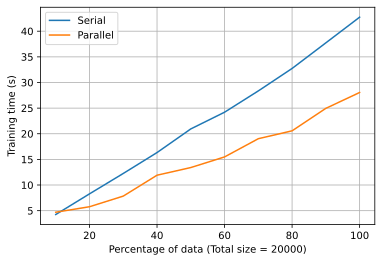

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(range(10, 100+10, 10), serial_times, label="Serial")
plt.plot(range(10, 100+10, 10), parallel_times, label="Parallel")

plt.xlabel(f"Percentage of data (Total size = {len(train)})")
plt.ylabel(f"Training time (s)")
plt.legend()
plt.grid()

Training times seem to be linear in dataset size. We observe an improvement in training time with parallel processing by a fixed factor. Note that there is negligible overhead with parallelization and significant speedup of more than 1.5x!

### Results with four levels

In [40]:
update_results(results, parallel).T.drop(['xgb_pll_1', 'blender_rk_pll_1'], axis=1)

,lr_0,lr_cnt_0,rf_svd_0,xgb_1,blender_1,blender_rk_1,blender_3
cv_roc,0.9322 ± 0.0038,0.9439 ± 0.0038,0.8782 ± 0.0034,0.9439 ± 0.0038,0.9485 ± 0.0038,0.9493 ± 0.0038,0.9488 ± 0.0038
cv_acc,0.8565 ± 0.0036,0.8786 ± 0.0047,0.7978 ± 0.0011,0.8778 ± 0.0035,0.8687 ± 0.0101,NaN,NaN
test_roc,0.9404,0.9473,0.8794,0.9498,0.9538,0.9537,0.9543
test_acc,0.871,0.8838,0.7976,0.886,0.8794,NaN,NaN


Looks like deeper is not always better: we observe some indication of overfitting in the form of decreased cv score.